This notebook provides an example workflow of bin2cell, with corresponding results presented.

In [2]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os

import bin2cell as b2c

In [3]:
## READ-IN DATA, LOAD COUNT MATRIX
#create directory for stardist input/output files
os.makedirs("stardist", exist_ok=True)

path = "../Visium/binned_outputs/square_002um"
source_image_path = "../Visium/Visium_HD_Mouse_Brain_tissue_image.tif"
spaceranger_image_path = "../Visium/spatial"

adata = b2c.read_visium(path, 
                        source_image_path = source_image_path, 
                        spaceranger_image_path = spaceranger_image_path
                       )
adata.var_names_make_unique()
adata

anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 6296688 × 19059
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
## FILTER DATA
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
## CONTROL RESOLUTION OF INPUT IMAGE
mpp = 0.3
b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he.tiff") # image needs to be saved to the drive

Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.3_mpp_150_buffer


_construct.py (149): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


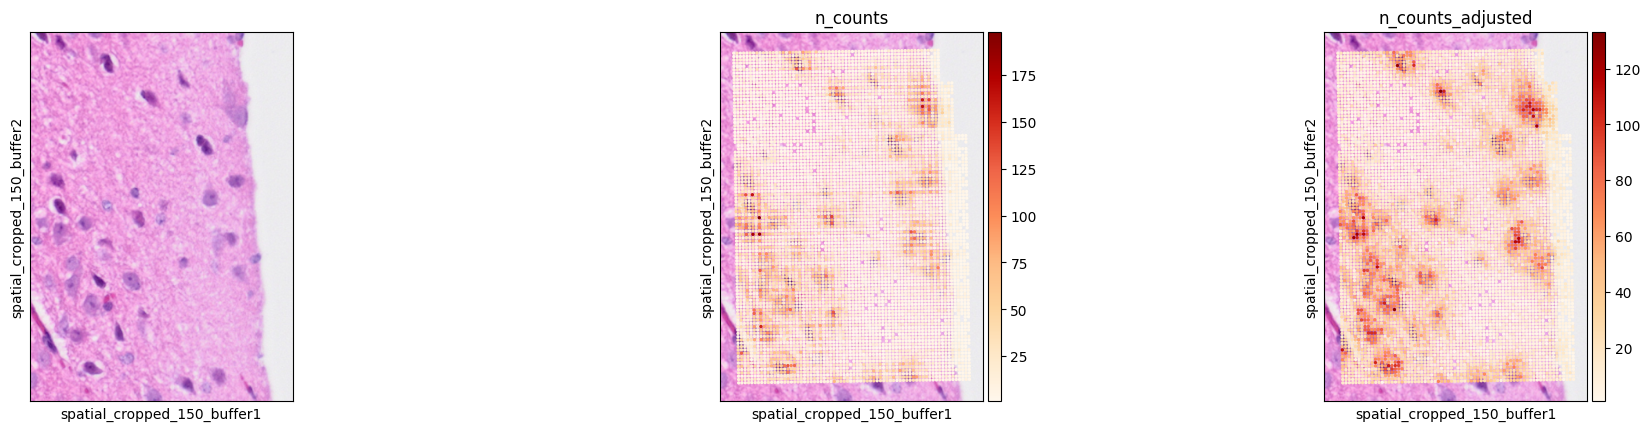

In [5]:
## DESTRIPE DATA, CROP, and PLOT
b2c.destripe(adata)
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 250) & 
        (adata.obs['array_col'] <= 450)
       )
bdata = adata[mask]

# Jupyter issue when plotting
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd",
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")

In [ ]:
## SEGMENTATION
b2c.stardist(image_path="stardist/he.tiff", 
             labels_npz_path="stardist/he.npz", # define the path where segmentation label is saved
             stardist_model="2D_versatile_he", 
             prob_thresh=0.01 # probability threshold: A lower threshold (0.01) means StarDist will detect more nuclei, including lower-confidence ones.
            )

b2c.insert_labels(adata, 
                  labels_npz_path="stardist/he.npz", # path to the labels generated by stardist
                  basis="spatial", 
                  spatial_key="spatial_cropped_150_buffer", # the key where the cropped image is stored
                  mpp=mpp, 
                  labels_key="labels_he" # where segmentation labels will be stored
                 )

# visualize
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_he']>0] # assigned labels
bdata.obs['labels_he'] = bdata.obs['labels_he'].astype(str)

2025-02-16 14:16:11.804621: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-16 14:16:12.067137: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-16 14:16:12.292984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739733372.491698 1111934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739733372.749539 1111934 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 14:16:13.258102: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Found model '2D_versatile_he' for 'StarDist2D'.
5294730/5294730 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


2025-02-16 14:17:11.018743: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  0%|                                                                                                                                                                                                      | 0/30 [00:00<?, ?it/s]functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, None, None, 3))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [24:20<00:00, 48.68s/it]


Found 91749 objects


4169567011.py (21): Trying to modify attribute `.obs` of view, initializing view as actual.


KeyError: '0.5_mpp_150_buffer'

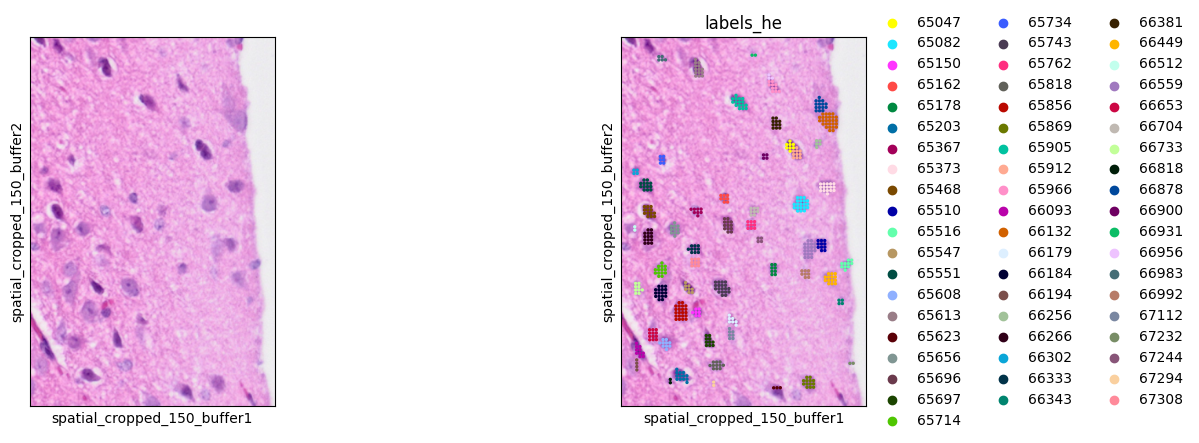

In [7]:
# plot, see on website
sc.pl.spatial(bdata, color=[None, "labels_he"], img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer") # basis = spatial coordinate basis

anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


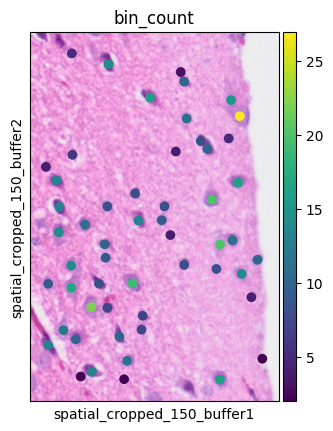

In [9]:
# GROUP BINS INTO CELLS
cdata = b2c.bin_to_cell(adata, labels_key="labels_he", spatial_keys=["spatial", "spatial_cropped_150_buffer"])
cell_mask = ((cdata.obs['array_row'] >= 1450) & 
             (cdata.obs['array_row'] <= 1550) & 
             (cdata.obs['array_col'] >= 250) & 
             (cdata.obs['array_col'] <= 450)
            )

ddata = cdata[cell_mask]
sc.pl.spatial(ddata, color=["bin_count"], 
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")
